# Film Junky Union

## 1. Contenido

* [1 Contenido](#content)
* [2 Introducción](#intro)
* [3 Inicialización](#inic)
    * [3.1 Cargar Librerias](#library)
    * [3.2 Cargar Datos](#datos)
* [4 Exploración y preparación los datos](#exprep) 
    * [4.1 Preprocesamiento](#prep)
    * [4.2 Exploración](#expl)
* [5  Procedimiento de evaluación](#train)
* [6 Normalización](#analisis)
* [7 División entrenamiento / prueba](#analisis)
* [8 Trabajar con modelos](#analisis)
    * [8.1 Modelo 0 - Constante](#prep)
    * [8.2 Modelo 1 - NLTK, TF-IDF y LR](#expl)
    * [8.3 Modelo 2 - spaCy, TF-IDF y CB](#expl)
    * [8.4 Modelo 3 - spaCy, TF-IDF y LGBMClassifier](#expl)
* [9 Mis reseñas](#analisis)
    * [9.1 Modelo 1](#prep)
    * [9.2 Modelo 2](#expl)
    * [9.3 Modelo 3](#expl)    
* [10 Conclusiones](#analisis)

## 2. Introducción

En el presente proyecto procederemos a desarrollar tres modelos de machine learning para la comunidad Film Junky Union con el objetivo de clasificar reseñas de forma automática, identificando las reseñas negativas y positivas, a partir de una base de datos de reseñas de IMDB las cuales vienen con una clasificación propia acerca del carácter de la reseña.

Comenzaremos revisando los datos proporcionados, realizaremos un análisis de los datos y desarrollaremos el modelo solicitado

## 3. Inicialización

### 3.1. Cargar librerias

Se procede a cargar las librerías que se utilizaran en el proyecto.

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm
import sklearn.metrics as metrics
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords as nltk_stopwords
from catboost import CatBoostClassifier
import spacy
from lightgbm import LGBMClassifier
import re

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
plt.style.use('seaborn')

### 3.2 Cargar datos

Se procede a cargar los datos.

In [3]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

## 4. Exploración y preparación los datos

### 4.1. Preparación

A continuación, procederemos a realizar una exploración sobre las bases de datos de IMDB.

In [4]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [5]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


Podemos observar que existen 2 valores nulos en dos columnas de la base de datos, específicamente "average_rating" y "votes", debido a que las columnas más importantes para el presente proyecto son la reseña de las películas y la valoración de la misma reseña es que procederemos a rellenar estos datos nulos con vales de "unknown" y continuaremos analizando específicamente las dos columnas de nuestro mayor interés.

In [6]:
df_reviews = df_reviews.fillna(0)

In [7]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47331 non-null  float64
 10  votes            47331 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [8]:
df_reviews.duplicated().sum()

0

En primera instancia podemos observar que no existen filas duplicadas.

In [9]:
df_reviews['review'].duplicated().sum()

91

Por el lado de las reseñas podemos apreciar que si existen reseñas duplicadas, esto podría deberse a que por coincidencia dos personas escribieran la misma reseña o que una misma persona utilizara como base una misma reseña para evaluar diferentes películas. Independiente de lo anterior y por el bajo número de reseñas repetidas en comparación con la cantidad total de datos es que se procederá a eliminar estas últimas para que no entorpezcan el procedimiento.

In [10]:
df_reviews['review'] = df_reviews['review'].drop_duplicates()
df_reviews = df_reviews.dropna()

Continuaremos observando si los valores en la columna "pos" corresponden a los valores de 0 y 1 que debieran ser, considerando que estos indican si la reseña es positiva o negativa.

In [11]:
df_reviews['pos'].unique()

array([0, 1])

Podemos observar que los valores son los correctos.

Finalmente observaremos el resultado final de la base de datos.

In [12]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47240 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47240 non-null  object 
 1   title_type       47240 non-null  object 
 2   primary_title    47240 non-null  object 
 3   original_title   47240 non-null  object 
 4   start_year       47240 non-null  int64  
 5   end_year         47240 non-null  object 
 6   runtime_minutes  47240 non-null  object 
 7   is_adult         47240 non-null  int64  
 8   genres           47240 non-null  object 
 9   average_rating   47240 non-null  float64
 10  votes            47240 non-null  Int64  
 11  review           47240 non-null  object 
 12  rating           47240 non-null  int64  
 13  sp               47240 non-null  object 
 14  pos              47240 non-null  int64  
 15  ds_part          47240 non-null  object 
 16  idx              47240 non-null  int64  
dtypes: Int64(1),

### 4.2. Exploración

Veamos el número de películas y reseñas a lo largo de los años.

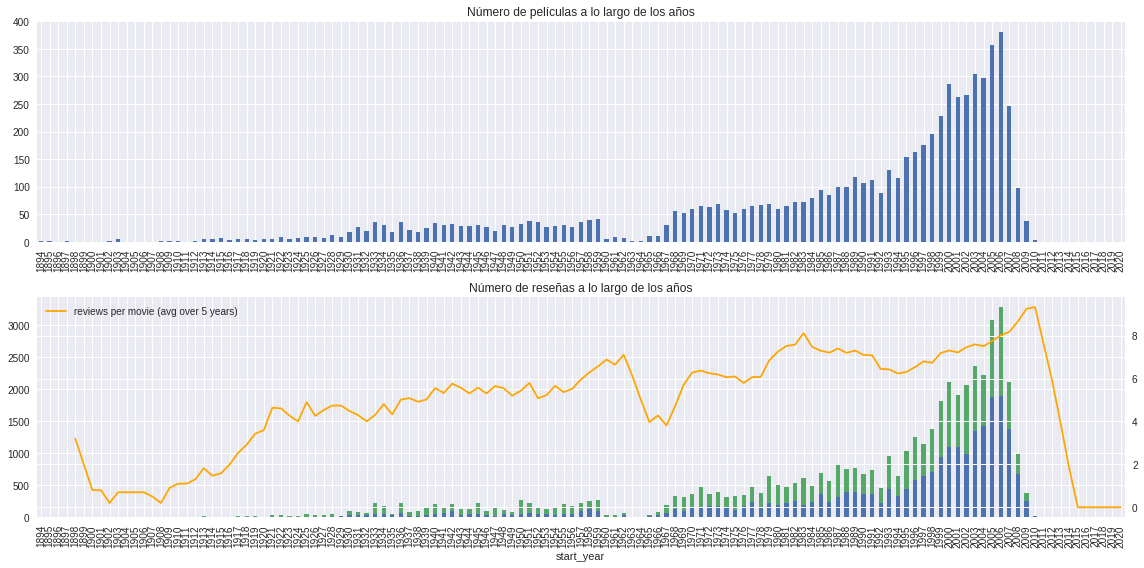

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Podemos apreciar como en términos generales el número de películas estrenadas aumenta cada años, excepto por un lapso entre 1960 y 1967, además de como las reseñas crecen paulatinamente a partir de 1920.

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

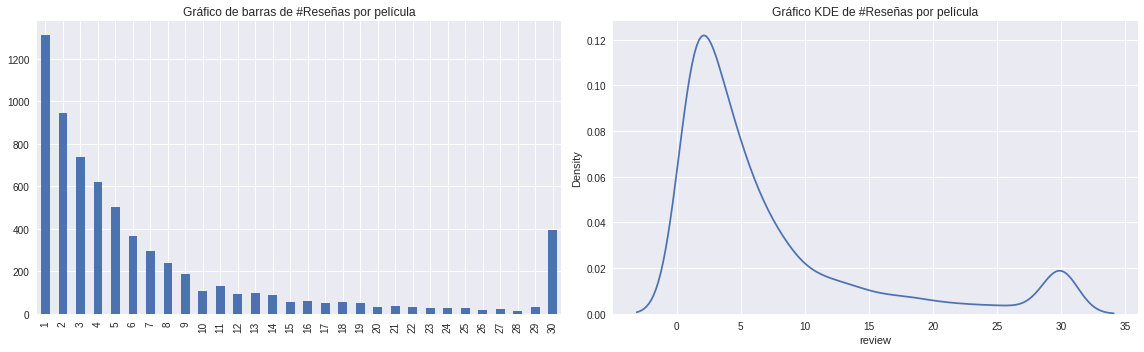

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

Al observar los gráficos de cantidad de reseñas por película podemos apreciar que este es descendiente, existiendo en mayor proporción una sola reseña por película y disminuyendo exponencialmente la cantidad de películas según aumenta el número de reseñas de la misma pero a su vez existiendo un gran aumento de películas al llegar a las 30 reseñas.

In [15]:
df_reviews['pos'].value_counts()

0    23680
1    23560
Name: pos, dtype: int64

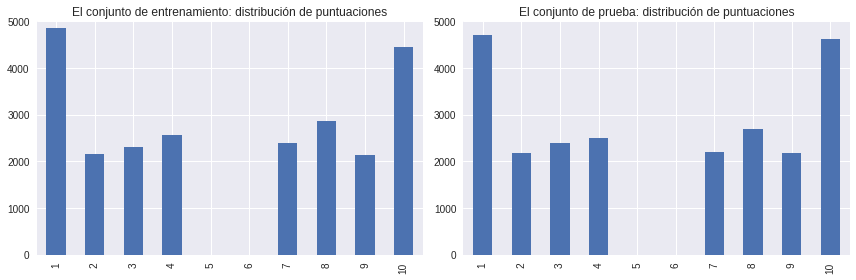

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Podemos apreciar que no existe un desequilibrio de clases en los conjuntos de prueba y entrenamiento, la distribución de las puntuaciones es similar en ambos conjuntos y los valores extremos en las puntuaciones son similares, siendo también similares los valores intermedios de puntuaciones entre ellas.

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

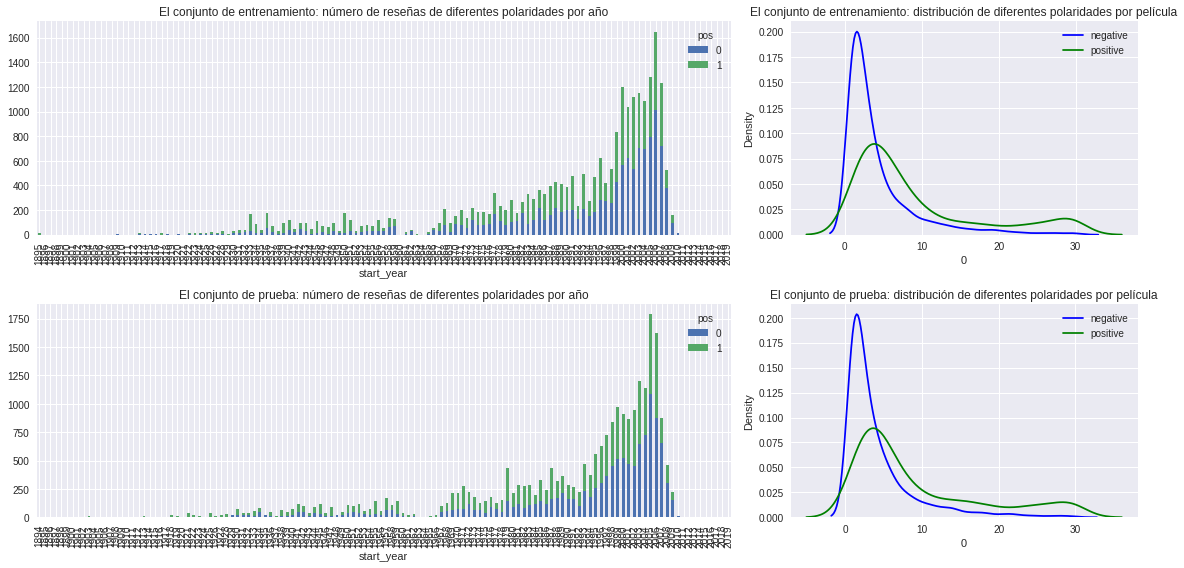

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

Finalmente al observar los gráficos podemos corroborar que las distribuciones de las polaridades de las reseñas en las muestras de entrenamiento y prueba es similar, podemos notar que la mayor densidad de reseñas negativas se encuentra en películas con pocas reseñas mientras las reseñas positivas aunque también encuentras su peak en películas con pocas reseñas igualmente poseen un aumento en las películas con alrededor de 30 reseñas, corroborando lo mencionado en los gráficos de reseñas por películas anteriormente observados.

## 5. Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [18]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## 6. Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [19]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

Creamos una función para normalizar las reseñas.

In [20]:
def normalize(text):
    pattern = r"[^a-zA-Z']"
    clear = re.sub(pattern, " ", text)
    clear = clear.split()
    clear = " ".join(clear)
    
    doc = nlp(clear.lower())
    lemmas = []
    for token in doc:
        lemmas.append(token.lemma_)
        
    return ' '.join(lemmas)

In [21]:
df_reviews['review_norm'] = df_reviews.apply(lambda x: normalize(x['review']), axis=1)

Observaremos la primera reseña versus su versión normalizada.

In [22]:
df_reviews.iloc[0,11]

"The pakage implies that Warren Beatty and Goldie Hawn are pulling off a huge bank robbery, but that's not what I got out of it! I didn't get anything! In the first half there's a new character (without introduction) in every other scene. The first half-hour is completely incomprehensible, the rest is just one long, annoying, underlit chase scene. There's always an irritating sound in the background whether it's a loud watch ticking, a blaring siren, a train whistling, or even the horrible score by Quincy Jones. There are a lot of parts that are laughably bad, too. Like, the bad guys chasing Beatty on thin ice with a CAR! Or, the police arriving at the scene roughly fifteen times. I really hated this movie!"

In [23]:
df_reviews.iloc[0,17]

'the pakage imply that warren beatty and goldie hawn be pull off a huge bank robbery but that be not what I get out of it I do not get anything in the first half there be a new character without introduction in every other scene the first half hour be completely incomprehensible the rest be just one long annoying underlit chase scene there be always an irritate sound in the background whether it be a loud watch tick a blaring siren a train whistle or even the horrible score by quincy jones there be a lot of part that be laughably bad too like the bad guy chase beatty on thin ice with a car or the police arrive at the scene roughly fifteen time I really hate this movie'

## 7. División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [24]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23757, 18)
(23483, 18)


## 8. Trabajar con modelos

### 8.1 Modelo 0 - Constante

In [25]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(df_reviews_train, train_target)

DummyClassifier(strategy='most_frequent')

           train  test
Exactitud    NaN   NaN
F1           0.0   0.0
APS          0.5   0.5
ROC AUC      0.5   0.5


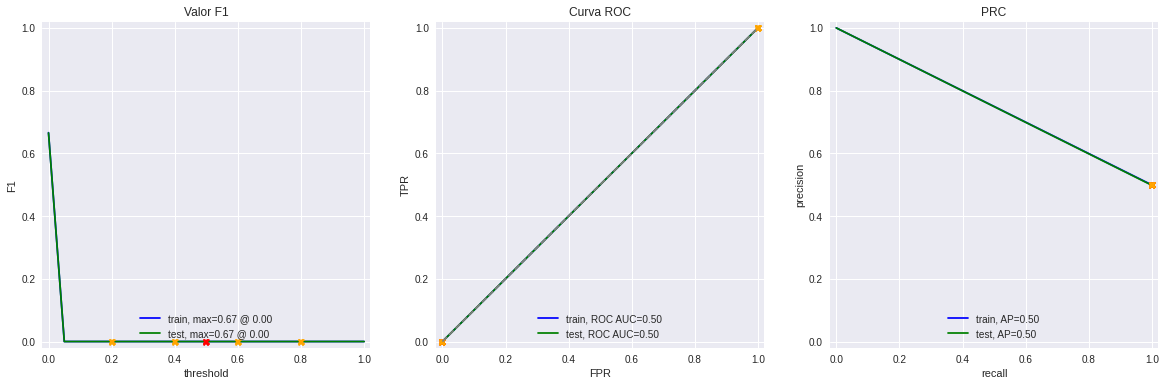

In [26]:
evaluate_model(dummy, df_reviews_train['review'], train_target, df_reviews_test['review'], test_target)

### 8.2 Modelo 1 - NLTK, TF-IDF y LR

In [27]:
corpus = df_reviews_train['review_norm']
stop_words = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stop_words)
train_features_1 = count_tf_idf.fit_transform(corpus)

In [28]:
corpus_test = df_reviews_test['review']
test_features_1 = count_tf_idf.transform(corpus_test)

In [29]:
model_1 = LogisticRegression(random_state=12345)
model_1.fit(train_features_1, train_target)

LogisticRegression(random_state=12345)

           train  test
Exactitud    NaN   NaN
F1          0.93  0.87
APS         0.98  0.94
ROC AUC     0.98  0.94


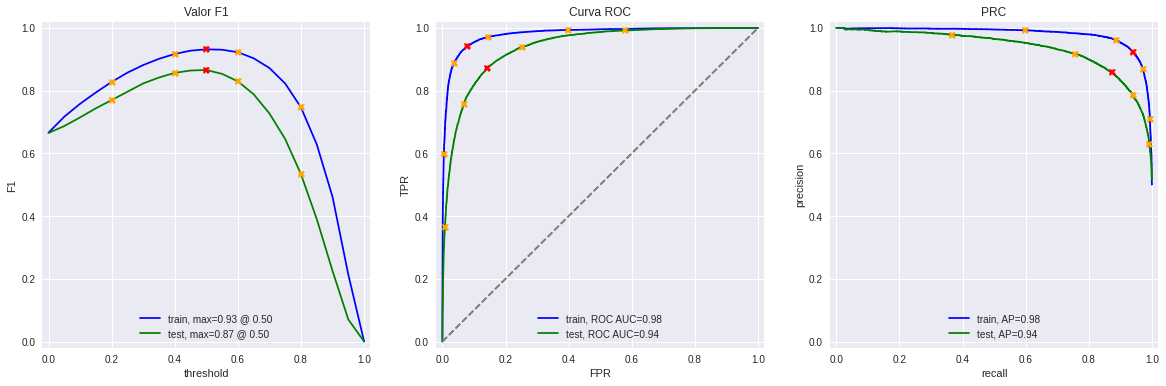

In [30]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### 8.3 Modelo 2 - spaCy, TF-IDF y CB

In [31]:
en = spacy.load('en_core_web_sm')

In [32]:
corpus_2 = df_reviews_train['review_norm']
stopwords_2 = nlp.Defaults.stop_words
count_tf_idf_2 = TfidfVectorizer(stop_words=stopwords_2)
train_features_2 = count_tf_idf_2.fit_transform(corpus_2)

/opt/conda/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [33]:
corpus_test_2 = df_reviews_test['review']
test_features_2 = count_tf_idf_2.transform(corpus_test_2)

In [34]:
model_2 = CatBoostClassifier(learning_rate=0.1)
model_2.fit(train_features_2, train_target)

0:	learn: 0.6663184	total: 2.03s	remaining: 33m 50s
1:	learn: 0.6405165	total: 3.73s	remaining: 30m 59s
2:	learn: 0.6217891	total: 5.46s	remaining: 30m 16s
3:	learn: 0.6059296	total: 7.24s	remaining: 30m 1s
4:	learn: 0.5929463	total: 8.95s	remaining: 29m 41s
5:	learn: 0.5820598	total: 10.6s	remaining: 29m 23s
6:	learn: 0.5725262	total: 12.3s	remaining: 29m 7s
7:	learn: 0.5647393	total: 14s	remaining: 28m 56s
8:	learn: 0.5579145	total: 15.7s	remaining: 28m 51s
9:	learn: 0.5511970	total: 17.4s	remaining: 28m 41s
10:	learn: 0.5443990	total: 19.1s	remaining: 28m 34s
11:	learn: 0.5384354	total: 20.8s	remaining: 28m 28s
12:	learn: 0.5334356	total: 22.5s	remaining: 28m 30s
13:	learn: 0.5285950	total: 24.2s	remaining: 28m 25s
14:	learn: 0.5244937	total: 25.9s	remaining: 28m 21s
15:	learn: 0.5207332	total: 27.6s	remaining: 28m 16s
16:	learn: 0.5168311	total: 29.4s	remaining: 28m 17s
17:	learn: 0.5133031	total: 31s	remaining: 28m 12s
18:	learn: 0.5098066	total: 32.7s	remaining: 28m 7s
19:	learn:

           train  test
Exactitud    NaN   NaN
F1          0.98  0.85
APS         1.00  0.92
ROC AUC     1.00  0.93


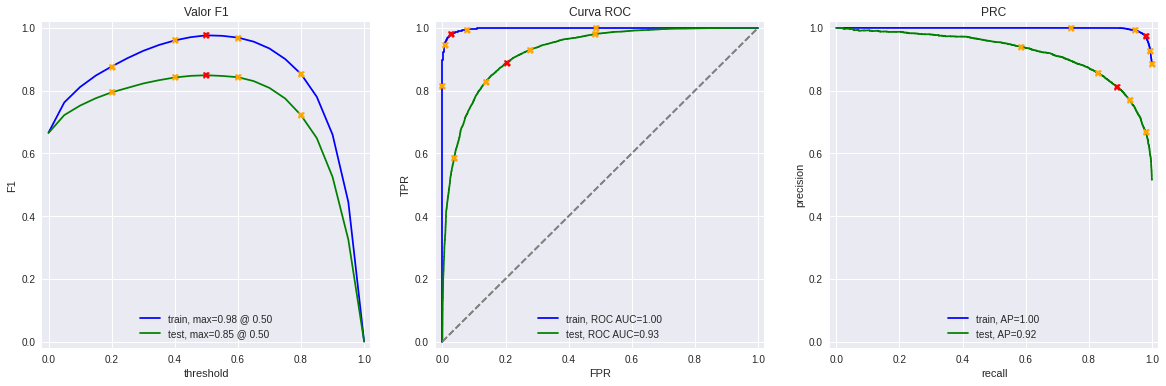

In [35]:
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

### 8.4 Modelo 3 - spaCy, TF-IDF y LGBMClassifier

In [36]:
corpus_3 = df_reviews_train['review_norm']
stopwords_3 = nlp.Defaults.stop_words
count_tf_idf_3 = TfidfVectorizer(stop_words=stopwords_3)
train_features_3 = count_tf_idf_3.fit_transform(corpus_3)

/opt/conda/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [37]:
corpus_test_3 = df_reviews_test['review']
test_features_3 = count_tf_idf_3.transform(corpus_test_3)

In [38]:
model_3 = LGBMClassifier(num_leaves=100)
model_3.fit(train_features_3, train_target)

LGBMClassifier(num_leaves=100)

           train  test
Exactitud    NaN   NaN
F1          0.98  0.85
APS         1.00  0.92
ROC AUC     1.00  0.92


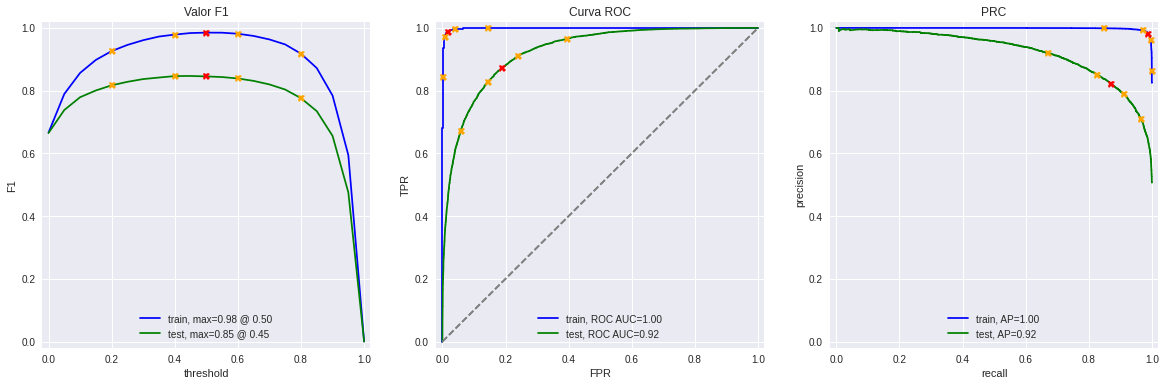

In [39]:
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

Podemos apreciar que los tres modelos desarrollados cumplen con el valor F1 mínimo establecido de 0.85 y superan ampliamente al modelo dummy.

## 9. Mis reseñas

In [40]:
my_reviews = pd.DataFrame([
    'There’s something morally deadening and aesthetically depressing about the bottomless toy chest of C.G.I. being reduced to the toolbox of cinematic bureaucracy.',
    'A straightforward action. It starts and it doesn’t stop.',
    'It’s distinguished itself just enough to satiate action film fans, entertain future streaming audiences and warrant further merging into the DC universe.',    
    'A muddled mess of a movie.',
    'For all the big fights, glowing CGI and mean mugging the Rock can do, this film is startlingly lifeless for having been in the works for so long.',
    'It never tries to be more than it is: the origin tale of a superentity that toes the line. Not because he might be evil. Because good isn’t always enough to defeat evil alone.',
    'Because Black Adam is such an angry anti-hero, Johnson’s personality is dialed all the way down to zero. Black Adam could have been a completely animated Vocaloid and we wouldn’t have known the difference.',
], columns=['review'])

my_reviews['review_norm'] = my_reviews.apply(lambda x: normalize(x['review']), axis=1)

my_reviews

,review,review_norm
0,There’s something morally deadening and aesthe...,there s something morally deaden and aesthetic...
1,A straightforward action. It starts and it doe...,a straightforward action it start and it doesn...
2,It’s distinguished itself just enough to satia...,it s distinguish itself just enough to satiate...
3,A muddled mess of a movie.,a muddled mess of a movie
4,"For all the big fights, glowing CGI and mean m...",for all the big fight glow cgi and mean mug th...
5,It never tries to be more than it is: the orig...,it never try to be more than it be the origin ...
6,"Because Black Adam is such an angry anti-hero,...",because black adam be such an angry anti hero ...


### 9.1 Modelo 1

In [41]:
texts = my_reviews['review']

my_reviews_pred_prob = model_1.predict_proba(count_tf_idf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.34:  There’s something morally deadening and aesthetically depressing about the bottomless toy chest of C
0.58:  A straightforward action. It starts and it doesn’t stop.
0.61:  It’s distinguished itself just enough to satiate action film fans, entertain future streaming audien
0.14:  A muddled mess of a movie.
0.32:  For all the big fights, glowing CGI and mean mugging the Rock can do, this film is startlingly lifel
0.49:  It never tries to be more than it is: the origin tale of a superentity that toes the line. Not becau
0.28:  Because Black Adam is such an angry anti-hero, Johnson’s personality is dialed all the way down to z


### 9.2 Modelo 2

In [42]:
texts = my_reviews['review']

my_reviews_pred_prob_2 = model_2.predict_proba(count_tf_idf_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_2[i]:.2f}:  {review}')

0.60:  There’s something morally deadening and aesthetically depressing about the bottomless toy chest of C
0.64:  A straightforward action. It starts and it doesn’t stop.
0.70:  It’s distinguished itself just enough to satiate action film fans, entertain future streaming audien
0.37:  A muddled mess of a movie.
0.50:  For all the big fights, glowing CGI and mean mugging the Rock can do, this film is startlingly lifel
0.76:  It never tries to be more than it is: the origin tale of a superentity that toes the line. Not becau
0.55:  Because Black Adam is such an angry anti-hero, Johnson’s personality is dialed all the way down to z


### 9.3 Modelo 3

In [43]:
texts = my_reviews['review']

my_reviews_pred_prob_3 = model_3.predict_proba(count_tf_idf_3.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_3[i]:.2f}:  {review}')

0.61:  There’s something morally deadening and aesthetically depressing about the bottomless toy chest of C
0.67:  A straightforward action. It starts and it doesn’t stop.
0.79:  It’s distinguished itself just enough to satiate action film fans, entertain future streaming audien
0.16:  A muddled mess of a movie.
0.59:  For all the big fights, glowing CGI and mean mugging the Rock can do, this film is startlingly lifel
0.92:  It never tries to be more than it is: the origin tale of a superentity that toes the line. Not becau
0.55:  Because Black Adam is such an angry anti-hero, Johnson’s personality is dialed all the way down to z


## 10. Conclusiones

Al observar el resultado de las reseñas de los tres modelos, podemos apreciar que, aunque las calificaciones de los modelos se parecen, otorgándole los menores puntajes a las reseñas que son realmente negativas y mayores a las reseñas más positivas estos se mueven en escalas distintas. 

 El primer modelo el cual posee el mayor valor F1 en el conjunto de prueba otorga la valoración más acertada a las distintas reseñas, pero lo hace en una escala más baja que el resto de los modelos, siendo su valoración mínima de 0.14 para la reseña negativa más corta y concisa de todas, que todos los modelos la clasifican como la más negativa, y teniendo como valor máximo para una reseña positiva un valor de 0.61. Independiente de lo anterior, este modelo es el que clasifica de mejor forma las distintas reseñas.
 
 El segundo modelo sube su escala de puntuaciones con respecto al segundo, calificando entre 0.37 y 0.7 las reseñas. En comparación con el primer modelo no posee tanta precisión calificando reseñas al puntuar con el valor más alto una reseña que no es del todo positiva.
 
 El tercer modelo actúa de forma similar al segundo modelo, aumentando el rango de puntuación de las reseñas entre 0.16 y 0.92 pero vuelve a tener problemas con la quinta reseña clasificándola como si fuera la más positiva de todas cuando en realidad es positiva, pero deja algunas cualidades negativas en la misma reseña, por lo que tendría que tener una clasificación más intermedia.

Podemos concluir que en general los modelos cumplen sus objetivos, se puede apreciar que entre más cortas sean las reseñas, más fácil es para los mismos el poder catalogarlas de una forma más contundente, mientras que reseñas largas pueden llegar a confundir a los modelos. En este caso el modelo que mejor comportamiento tuvo fue el basado en la regresión logística tanto en su evaluación con las muestras de entrenamiento y prueba como con las reseñas evaluadas ajenas a la base de datos.